In [1]:
import warnings 
from typing import List, Dict
from math import pi
from itertools import batched
import pennylane as qml
import pennylane.numpy as np
from scipy.optimize import minimize
from qiskit.visualization import plot_histogram
from data import relations, starting_point, labels, labels_index, nodes_index_relations_split, encode_angle
from tqdm import trange
  
  
warnings.filterwarnings('ignore') 

![graph](./assets/graph.png)

In [2]:
farest_distance = max(list(relations.values()))
print(f"Farest Distance: {farest_distance}")

Farest Distance: 9.8


In [3]:
n_qubits = len(labels)-1
dev = qml.device('qiskit.aer', wires=n_qubits, shots=1000)

In [37]:
@qml.qnode(dev)
def model(points:List[float], weights:List[List[float]])->List[Dict[np.str_, np.int64]]:
    weights = np.reshape(weights, (1,1,n_qubits))
    for qubit,distance in enumerate(points):
        angle = encode_angle(distance, farest_distance)
        qml.RY(angle, wires=qubit)
        
    qml.Barrier(wires=range(n_qubits))
    qml.BasicEntanglerLayers(rotation=qml.RX, wires=range(n_qubits), weights=weights)

    return qml.counts()

In [14]:
def get_distances_from_label(label:str, distances:Dict) -> List[float]:
    items = distances.items()
    label_filter = lambda item: item[0][0] != item[0][1] and item[0][0] == label
    get_distance = lambda item:item[-1]
    return list(map(get_distance, filter(label_filter, items)))

[{np.str_('0000'): np.int64(12), np.str_('0001'): np.int64(57), np.str_('0010'): np.int64(64), np.str_('0011'): np.int64(146), np.str_('0100'): np.int64(89), np.str_('0101'): np.int64(103), np.str_('0110'): np.int64(22), np.str_('0111'): np.int64(15), np.str_('1000'): np.int64(21), np.str_('1001'): np.int64(14), np.str_('1010'): np.int64(167), np.str_('1011'): np.int64(43), np.str_('1100'): np.int64(90), np.str_('1101'): np.int64(104), np.str_('1110'): np.int64(32), np.str_('1111'): np.int64(21)}]


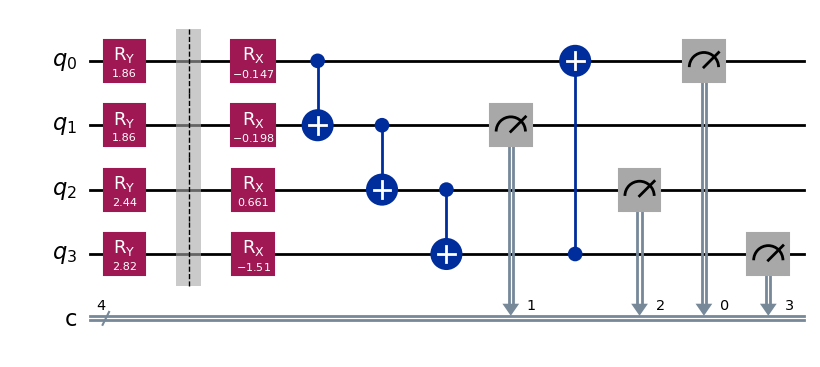

In [34]:
weights = np.random.uniform(-pi/2, pi/2, size=n_qubits, requires_grad=True)
points_from_A = get_distances_from_label(starting_point, relations)
print(model(points_from_A,weights))
dev._circuit.draw('mpl')

In [57]:
def get_next_node(bit_string:str, current_node:str)->str:
    if(not '1' in bit_string):
        return current_node

    value_one_index = bit_string.index('1')
    current_node_index = labels_index[current_node]
    return nodes_index_relations_split[current_node_index][value_one_index]

In [94]:
def objective_fn(weights):
    get_most_likely_bit_string = lambda x: x[-1]

    visited_nodes = [starting_point]
    bit_strings = []
    current_label = visited_nodes[-1]
    total = 0

    for _ in range(4):
        distances = get_distances_from_label(current_label, relations)
        total_ones = 2
        resulting_bit_string = ''

        while total_ones > 1:
            results = model(distances, weights)[0]
            results_items = results.items()

            resulting_bit_string,__ = max(results_items, key=get_most_likely_bit_string)
            total_ones = resulting_bit_string.count('1')
            print(total_ones, resulting_bit_string)
        

        bit_strings.append(resulting_bit_string)

        next_node = get_next_node(resulting_bit_string, current_label)

        total += relations[f'{current_label}{next_node}']
        
        visited_nodes.append(next_node)
        current_label = next_node

    total_equal = len(visited_nodes)-len(set(visited_nodes))
    result = total_equal
    print(f">> total: {total}; equal: {total_equal}; {visited_nodes}; {bit_strings} objective result: {result}")
    return result

In [95]:
minimized_values = minimize(objective_fn, method="COBYLA", x0=weights)

2 0011
2 1010
2 1010
2 1010
2 1010
2 1010
2 0011
2 1010
2 1010
2 1010
2 1010
2 1010
2 1010
2 1010
2 1010
2 1010
2 1010
2 1010
2 0011
2 1010
2 1010
2 1010
2 1010
2 1010
2 1010
2 1010
2 1010
2 1010
2 1010
2 1010
2 0011
2 1010
2 1010
2 1010
2 1010
2 1010
2 1010
2 1010
2 1010
2 1010
2 1010
2 1010
2 1010
2 1010
2 1010
2 1010
2 1010
2 0011
2 1010
2 1010
2 1010
2 1010
2 1010
2 1010
2 1010
2 1010
2 1010
2 1010
2 1010
2 1010
2 1010
2 1010
2 1010
2 1010
2 0011
2 1010
2 1010
2 0011
2 0011
2 1010
2 1010
2 1010
2 1010
2 0011
2 1010
2 1010
2 1010
2 1010
2 1010
2 1010
2 1010
2 1010
2 1010
2 1010
2 0011
2 1010
2 1010
2 1010
2 1010
2 1010
2 1010
2 1010
2 1010
2 1010
2 1010
2 1010
2 1010
2 1010
2 1010
2 1010
2 1010
2 1010
2 1010
2 1010
2 1010
2 1010
2 1010
2 0011
2 1010
2 1010
2 0011
2 0011
2 1010
2 1010
2 1010
2 1010
2 1010
2 1010
2 0011
2 1010
2 1010
2 1010
2 1010
2 1010
2 1010
2 1010
2 1010
2 0011
2 1010
2 1010
2 1010
2 1010
2 1010
2 1010
2 1010
2 1010
2 0011
2 1010
2 0011
2 1010
2 1010
2 1010
2 1010

KeyboardInterrupt: 

In [10]:
weights = minimized_values.x

In [11]:
with open('qml-version-weights.npy','wb') as file:
    np.save(file, weights)

In [12]:
point = starting_point
for i in range(5):
    results = model(get_distances_from_label(point, relations), weights)
    results_items = results.items()

    bit_string, total = max(results_items, key=lambda x: x[-1])
    next_point = get_next_node(bit_string, point)

    print(f'step {i}: {point} --> {bit_string}={total}={next_point}')

    point = next_point

step 0: A --> 1000=570=B
step 1: B --> 1000=518=A
step 2: A --> 1000=559=B
step 3: B --> 1000=507=A
step 4: A --> 1000=581=B
